# Initialisation

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.linalg as lin
import scipy.sparse as sp

from tqdm import tqdm

from Ising import *
from Ising3D import *
from plot_tools import *

# 2-D Ising model

In [46]:
Nx,Ny = 5,5

g = 1
beta = 10

config = random_lattice(Nx,Ny)

i,j = np.random.randint(low=0,high=Nx),np.random.randint(low=0,high=Ny)

config_flip = np.copy(config)
config_flip[i,j] *= -1

dE = calcEnergy(config_flip,Nx,Ny,g)[0] - calcEnergy(config,Nx,Ny,g)[0]

dE2 = delta_energy_flip(config,i,j,Nx,Ny,g)

print(dE,dE2)

0 0


## Magnetisation

100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


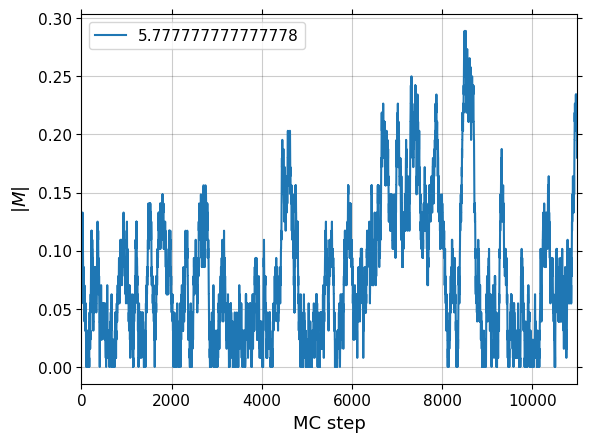

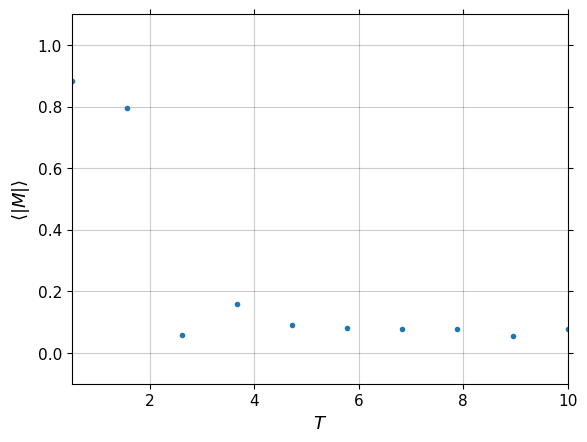

In [58]:
Nx, Ny = 16, 16 # size of the lattice
g = 1

Neq = 1000 # number of MC steps for equilibrium
Nsteps = 10000 # number of MC sample for average

T = np.linspace(0.5,10,10)
M = np.zeros(len(T))

create_plot('MC step',r'$|M|$',[0,Nsteps+Neq])

for i in tqdm(range(len(T))) :

    t = T[i]
    M_burnin = np.zeros(Neq+Nsteps)
    config = random_lattice(Nx,Ny)


    # reach equilibrium
    for j in range(Neq) :
        config = MC_step(config,Nx,Ny,g,1/t)[0]
        M_burnin[j] = np.abs(mag(config))/(Nx*Ny)
    
        
    # sample for average
    Mt = np.zeros(Nsteps)

    for k in range(Nsteps) :
        config = MC_step(config,Nx,Ny,g,1/t)[0]
        Mt[k] = np.abs(mag(config))
        M_burnin[Neq+k] = np.abs(mag(config))/(Nx*Ny)

    #if i==1 or i==25 or i==50 or i==99 : plot_lattice(config,Nx,Ny)

    M[i] = np.sum(Mt)/(Nsteps*Nx*Ny)
    if i == 5 :plt.plot(range(Neq+Nsteps),M_burnin,label=str(t))
    
plt.legend()

Tc = 2*g/np.log(1+np.sqrt(2))
create_plot(r'$T$',r'$\langle |M|\rangle$',[T[0],T[-1]],ylim=[-0.1,1.1])
plt.plot(T,M,'.')  

plt.show()      

In [22]:
print(Tc)

2.269185314213022


# 3-D Ising

In [3]:
Nx,Ny,Nz = 3,3,3

J = 1
Gamma = 1
beta = 10

config = random_lattice3D(Nx,Ny,Nz)

i,j,k = np.random.randint(low=0,high=Nx),np.random.randint(low=0,high=Ny),np.random.randint(low=0,high=Nz)

config_flip = np.copy(config)
config_flip[i,j,k] *= -1

E = energy3D(config_flip,J,Gamma,beta)

E2 = energy3D(config,J,Gamma,beta) + delta_energy_flip3D(config,i,j,k,J,Gamma,beta)

print(E,E2)


-6.665394032178275 -6.665394032178275


## Magnetisation

100%|██████████| 50/50 [02:30<00:00,  3.02s/it]


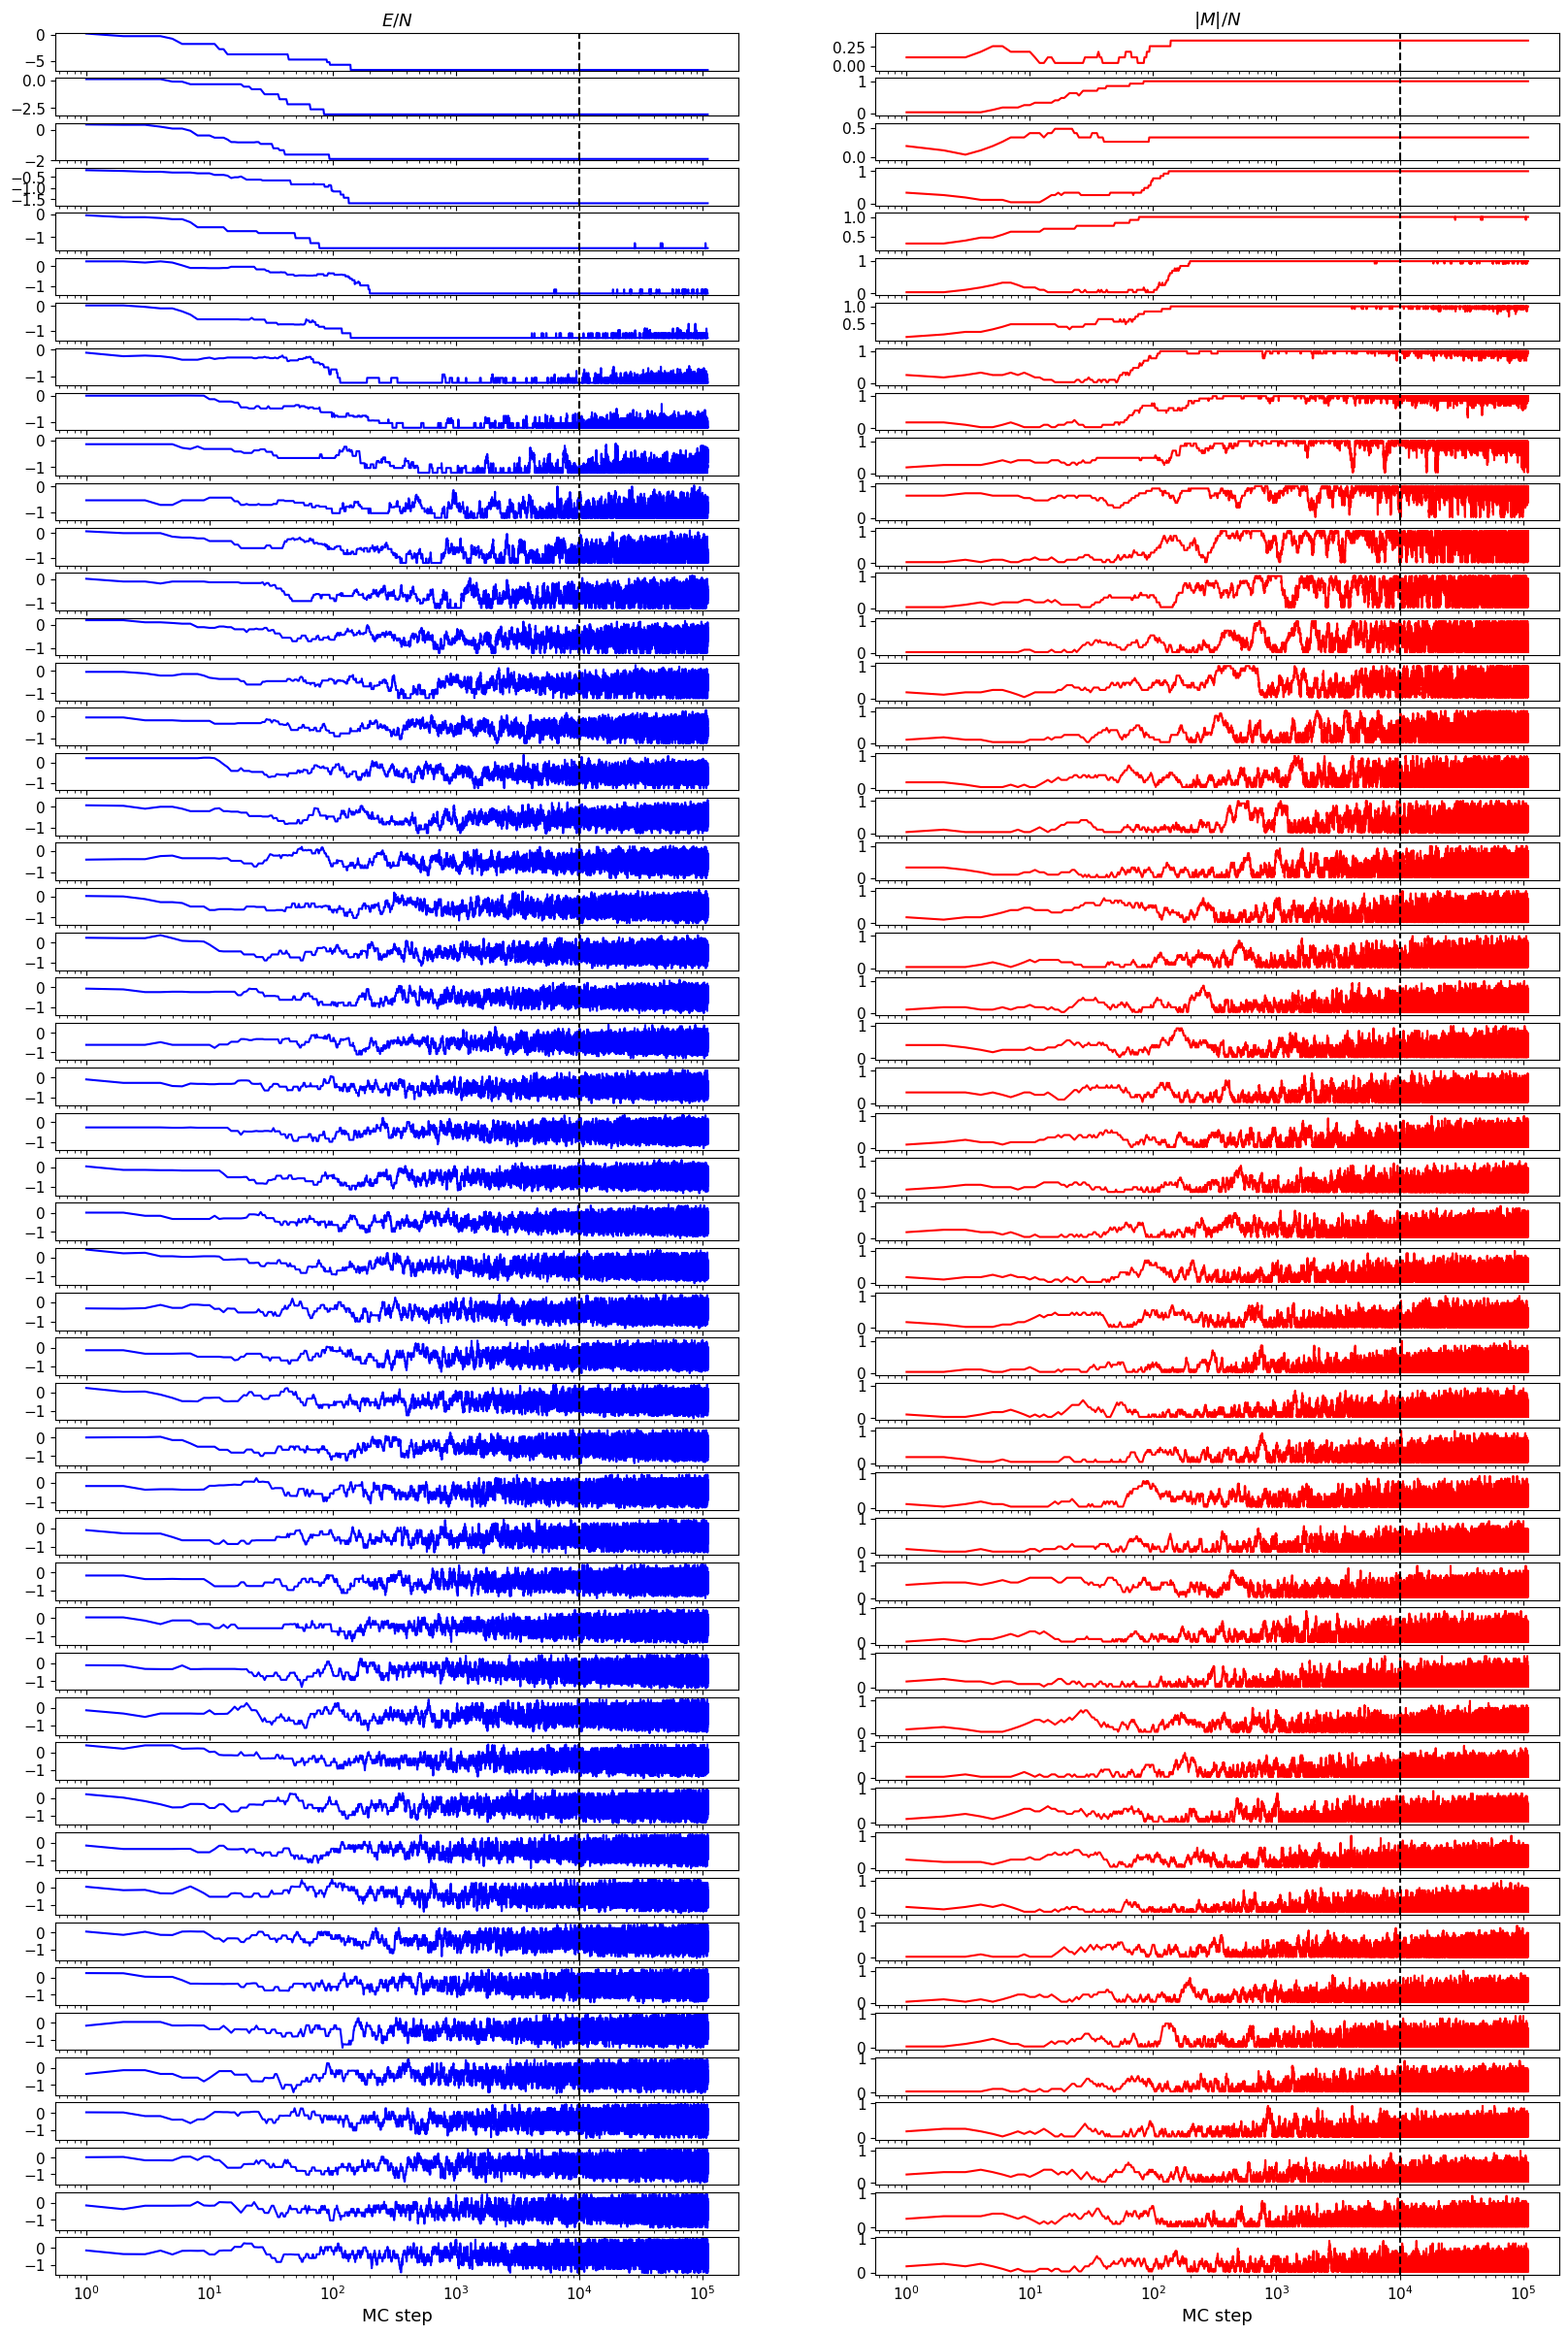

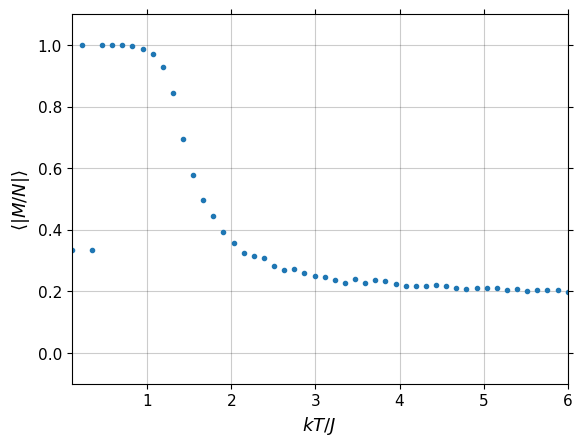

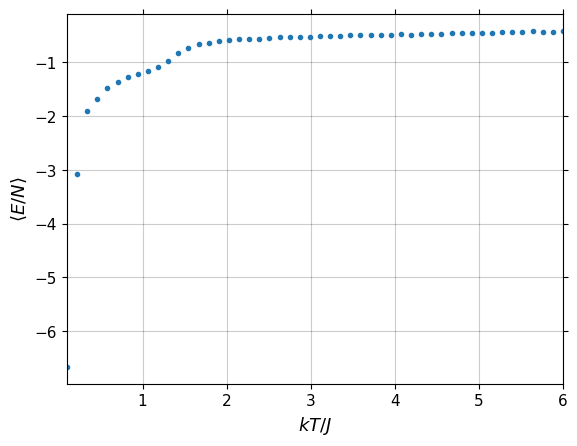

In [13]:
Nx, Ny, Nz = 3, 3, 3 # size of the lattice
J = 1
Gamma = 1

Neq = 10000 # number of MC steps for equilibrium
Nsteps = 100000 # number of MC sample for average

T = np.linspace(0.1,6,50)
M = np.zeros(len(T))
E = np.zeros(len(T))


fig, ax = plt.subplots(len(T),2,figsize=(20,30),sharex=True)
ax[-1,0].set_xlabel('MC step')
ax[0,0].set_title(r'$E/N$')
ax[-1,1].set_xlabel('MC step')
ax[0,1].set_title(r'$|M|/N$')

for i in tqdm(range(len(T))) :

    t = T[i]
    M_burnin = np.zeros(Neq+Nsteps)
    E_burnin = np.zeros(Neq+Nsteps+1)
    E_burnin2 = np.zeros(Neq+Nsteps+1)

    config = random_lattice3D(Nx,Ny,Nz)
    E_burnin[0] = energy3D(config,J,Gamma,1/t)


    # reach equilibrium
    for j in range(Neq) :
        config,dE,accepted = MC_step3D(config,J,Gamma,1/t)
        M_burnin[j] = np.abs(mag(config))
        if accepted :
            E_burnin[1+j] = E_burnin[j] + dE
        else :
            E_burnin[1+j] = E_burnin[j]

    # sample for average
    for k in range(Nsteps) :
    
        config,dE,accepted = MC_step3D(config,J,Gamma,1/t)
        M_burnin[Neq+k] = np.abs(mag(config))
        if accepted :
            E_burnin[Neq+1+k] = E_burnin[Neq+1+k-1] + dE
        else :
            E_burnin[Neq+1+k] = E_burnin[Neq+1+k-1]


    Mt = M_burnin[Neq:]
    Et = E_burnin[Neq:]

    M[i] = np.sum(Mt)/Nsteps
    E[i] = np.sum(Et)/Nsteps

    if i>=0 :
        ax[i,0].set_xscale('log')
        ax[i,0].plot(range(1,Neq+Nsteps+1),E_burnin[1:]/(Nx*Ny*Nz),color='b')
        ax[i,0].plot([Neq,Neq],[np.min(E_burnin/(Nx*Ny*Nz))-0.1,np.max(E_burnin/(Nx*Ny*Nz))+0.1],'--',color='black')
        ax[i,0].set_ylim([np.min(E_burnin/(Nx*Ny*Nz))-0.1,np.max(E_burnin/(Nx*Ny*Nz))+0.1])
       
        ax[i,1].set_xscale('log')
        ax[i,1].plot(range(1,Neq+Nsteps),M_burnin[1:]/(Nx*Ny*Nz),color='r')
        ax[i,1].plot([Neq,Neq],[np.min(M_burnin/(Nx*Ny*Nz))-0.1,np.max(M_burnin/(Nx*Ny*Nz))+0.1],'--',color='black')
        ax[i,1].set_ylim([np.min(M_burnin/(Nx*Ny*Nz))-0.1,np.max(M_burnin/(Nx*Ny*Nz))+0.1])

    

create_plot(r'$kT/J$',r'$\langle |M/N|\rangle$',[T[0]/J,T[-1]/J],ylim=[-0.1,1.1])
plt.plot(T/J,M/(Nx*Ny*Nz),'.')

create_plot(r'$kT/J$',r'$\langle E/N\rangle$',[T[0]/J,T[-1]/J])
plt.plot(T/J,E/(Nx*Ny*Nz),'.')

plt.show()

# Transverse Ising

In [14]:
N = 10
Ny = 10

def random_lattice(N, Ny) :

    lattice = np.array([[1 if np.random.uniform()<0.5 else -1 for i in range(N)] for j in range(Ny)])

    return lattice

def plot_lattice(lattice, N, Ny) :
    
    fig = plt.figure()
    x = np.arange(0,N,1)
    y = np.arange(0,Ny,1)

    for i in range(N) :
        for j in range(Ny) :
            if lattice[i,j] == 1 :
                color = 'r'
            else :
                color = 'b'
            plt.scatter([x[i]],[y[j]],color=color)

    plt.show()

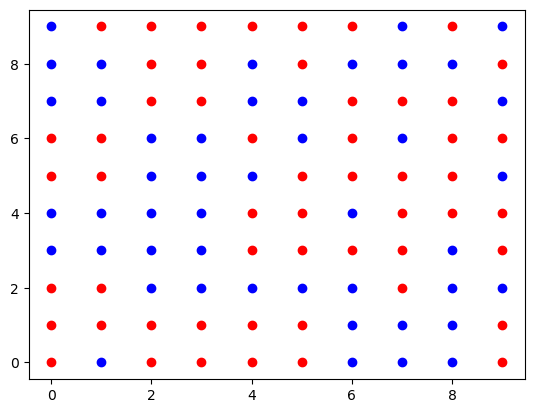

In [16]:
plot_lattice(random_lattice(N,Ny),N,Ny)

In [122]:
def plot_MH_sample(sample, Naccepted, Nsample, true_pdf) :

    create_plot('sample number',r'$x$',[0,len(sample)],title='Acceptance rate: '+str('{:.2f}'.format(Naccepted/Nsample)))

    plt.plot(np.arange(len(sample)),sample,marker='.')


    Nbin = 50
    x = np.linspace(0,10,10000)

    pdf = true_pdf(x)
    xmax = x[np.logical_and(pdf<1e-3,x>x[np.argmax(pdf)])][0]
    
    create_plot(r'$x$','distribution',[0,xmax])

    plt.hist(sample,bins=Nbin,density=True,histtype='step',label='MH sample')
    plt.plot(x,pdf,label='true PDF')

    plt.legend()
    plt.show()


def energy(lattice, N, Ny, g, beta):

    a = beta*g/Ny
    gamma = -np.log(np.tanh(a))

    E = 0

    lattice_periodic = np.zeros((N+1,Ny+1))
    lattice_periodic[0:N,0:Ny] = lattice
    lattice_periodic[-1,:-1] = lattice[0]
    lattice_periodic[:-1,-1] = lattice[:,0]

    for i in range(N) :
        for j in range(Ny) :

            ei =  -lattice_periodic[i,j]*(Ny*gamma/beta*lattice_periodic[i,j+1]+lattice_periodic[i+1,j])
            E += ei

    return E


def MC_step(config, N, Ny, g, beta) : # flips one spins and accept the new config with a certain probability

    candidate_lattice = np.copy(config)

    Eold = energy(candidate_lattice,N,Ny,g,beta)
    
    # flip one randomly chosen site

    a = np.random.randint(low=0,high=N)
    b = np.random.randint(low=0,high=Ny)
    candidate_lattice[a,b] = -candidate_lattice[a,b]

    # compute the new energy

    Enew = energy(candidate_lattice,N,Ny,g,beta)

    if Enew < Eold :
         return candidate_lattice

    else :

        a = np.exp(-beta*(Enew-Eold))
        
        if np.random.uniform() < a: # accept candidate if alpha>=1 or accept candidate with proba alpha if 0<alpha<1

            return candidate_lattice

        else: return config



def Monte_Carlo(N, Ny, g, beta, Nsample) :

    sample = np.zeros((Nsample,N,Ny))
    sample[0] = random_lattice(N,Ny)


    Naccepted = 0

    for i in tqdm(range(1,Nsample)):

        candidate_lattice = np.copy(sample[i-1])
        Eold = energy(candidate_lattice,N,Ny,g,beta)

        # flip one randomly chosen site

        a = np.random.randint(low=0,high=N)
        b = np.random.randint(low=0,high=Ny)
        candidate_lattice[a,b] = -candidate_lattice[a,b]

        # compute the new energy

        Enew = energy(candidate_lattice,N,Ny,g,beta)

        if Enew < Eold :
            sample[i] = np.copy(candidate_lattice)

        else :

            a = np.exp(-beta*(Enew-Eold))
        
            if np.random.uniform() < a: # accept candidate if alpha>=1 or accept candidate with proba alpha if 0<alpha<1

                sample[i] = np.copy(candidate_lattice)
                Naccepted += 1

            else: sample[i] = np.copy(sample[i-1])

        
    sample = sample[Nsample//10:] # remove beginning of the Markov chain
    
    return sample, Naccepted/Nsample



In [121]:
Monte_Carlo(100,100,1.3,1.4,10000)

  0%|          | 0/9999 [00:00<?, ?it/s]

100%|██████████| 9999/9999 [02:32<00:00, 65.67it/s]


(array([[[ 1., -1.,  1., ..., -1., -1.,  1.],
         [-1.,  1.,  1., ..., -1., -1., -1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.],
         ...,
         [ 1., -1., -1., ..., -1.,  1.,  1.],
         [ 1.,  1., -1., ...,  1., -1.,  1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.]],
 
        [[ 1., -1.,  1., ..., -1., -1.,  1.],
         [-1.,  1.,  1., ..., -1., -1., -1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.],
         ...,
         [ 1., -1., -1., ..., -1.,  1.,  1.],
         [ 1.,  1., -1., ...,  1., -1.,  1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.]],
 
        [[ 1., -1.,  1., ..., -1., -1.,  1.],
         [-1.,  1.,  1., ..., -1., -1., -1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.],
         ...,
         [ 1., -1., -1., ..., -1.,  1.,  1.],
         [ 1.,  1., -1., ...,  1., -1.,  1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.]],
 
        ...,
 
        [[ 1.,  1.,  1., ..., -1., -1., -1.],
         [ 1.,  1.,  1., ..., -1., -1., -1.],
         [ 1.,

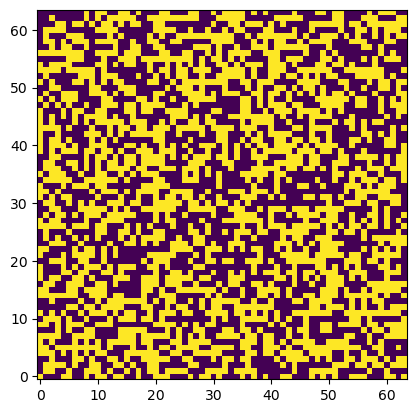

In [127]:
N,Ny = 64,64

lattice = random_lattice(N,Ny)

ax = plt.axes()

X,Y = np.meshgrid(range(N),range(Ny))

plt.pcolormesh(X,Y,lattice)

ax.set_aspect('equal')
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


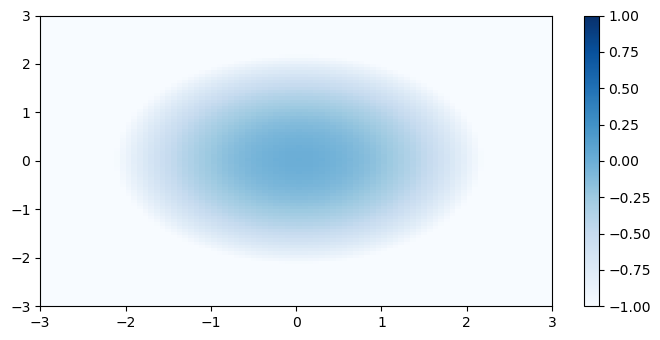

In [1]:
import numpy as np
from matplotlib import pyplot as plt, animation
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
x = np.linspace(-3, 3, 91)
t = np.linspace(0, 25, 30)
y = np.linspace(-3, 3, 91)
X3, Y3, T3 = np.meshgrid(x, y, t)
sinT3 = np.sin(2 * np.pi * T3 / T3.max(axis=2)[..., np.newaxis])
G = (X3 ** 2 + Y3 ** 2) * sinT3
cax = ax.pcolormesh(x, y, G[:-1, :-1, 0], vmin=-1, vmax=1, cmap='Blues')
fig.colorbar(cax)

def animate(i):
   cax.set_array(G[:-1, :-1, i].flatten())

anim = animation.FuncAnimation(fig, animate, interval=100, frames=len(t) - 1)
#anim.save('517.gif')
plt.show()